In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<h1 align="center">Colocalization and Distance Measurements of Objects in Fluorescence Microscopy</h1>

**Summary:**

1. SimpleITK provides a large number of filters that enable segmentation and quantification of the segmented objects characteristics and spatial relationships between the objects.

This notebook will illustrate the construction of a SimpleITK based analysis workflow in which we quantify the colocalization of two markers (FITC and Cy3) and the distance between the protein blobs these define to the nucleus blob(s) defined by a third marker (DAPI).

The image we work with was obtained by 3D Structured Illumination Microscopy (3D-SIM) and is provided courtesy of the Etienne Leygue lab at CancerCare Manitoba and The Genomic Centre for Cancer Research and Diagnosis.

*NOTE*: While SimpleITK is not aware of the units in the image spacing, these are implicitly assumed to be in mm. This is critical if you are computing sizes from a segmentation.

In [9]:
import SimpleITK as sitk
import numpy as np
import pandas as pd


%matplotlib notebook

#import matplotlib.pyplot as plt
import gui

%run update_path_to_download_script
from downloaddata import fetch_data as fdata

# Always write output to a separate directory, we don't want to pollute the source directory. 
import os
OUTPUT_DIR = 'Output'

%env SITK_SHOW_COMMAND /Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP

env: SITK_SHOW_COMMAND=/Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP


# Load data
Load the 3D multi channel structured illumination microscopy image, split it into the separate channels and display them.

Fetching microscopy_colocalization.nrrd


<IPython.core.display.Javascript object>


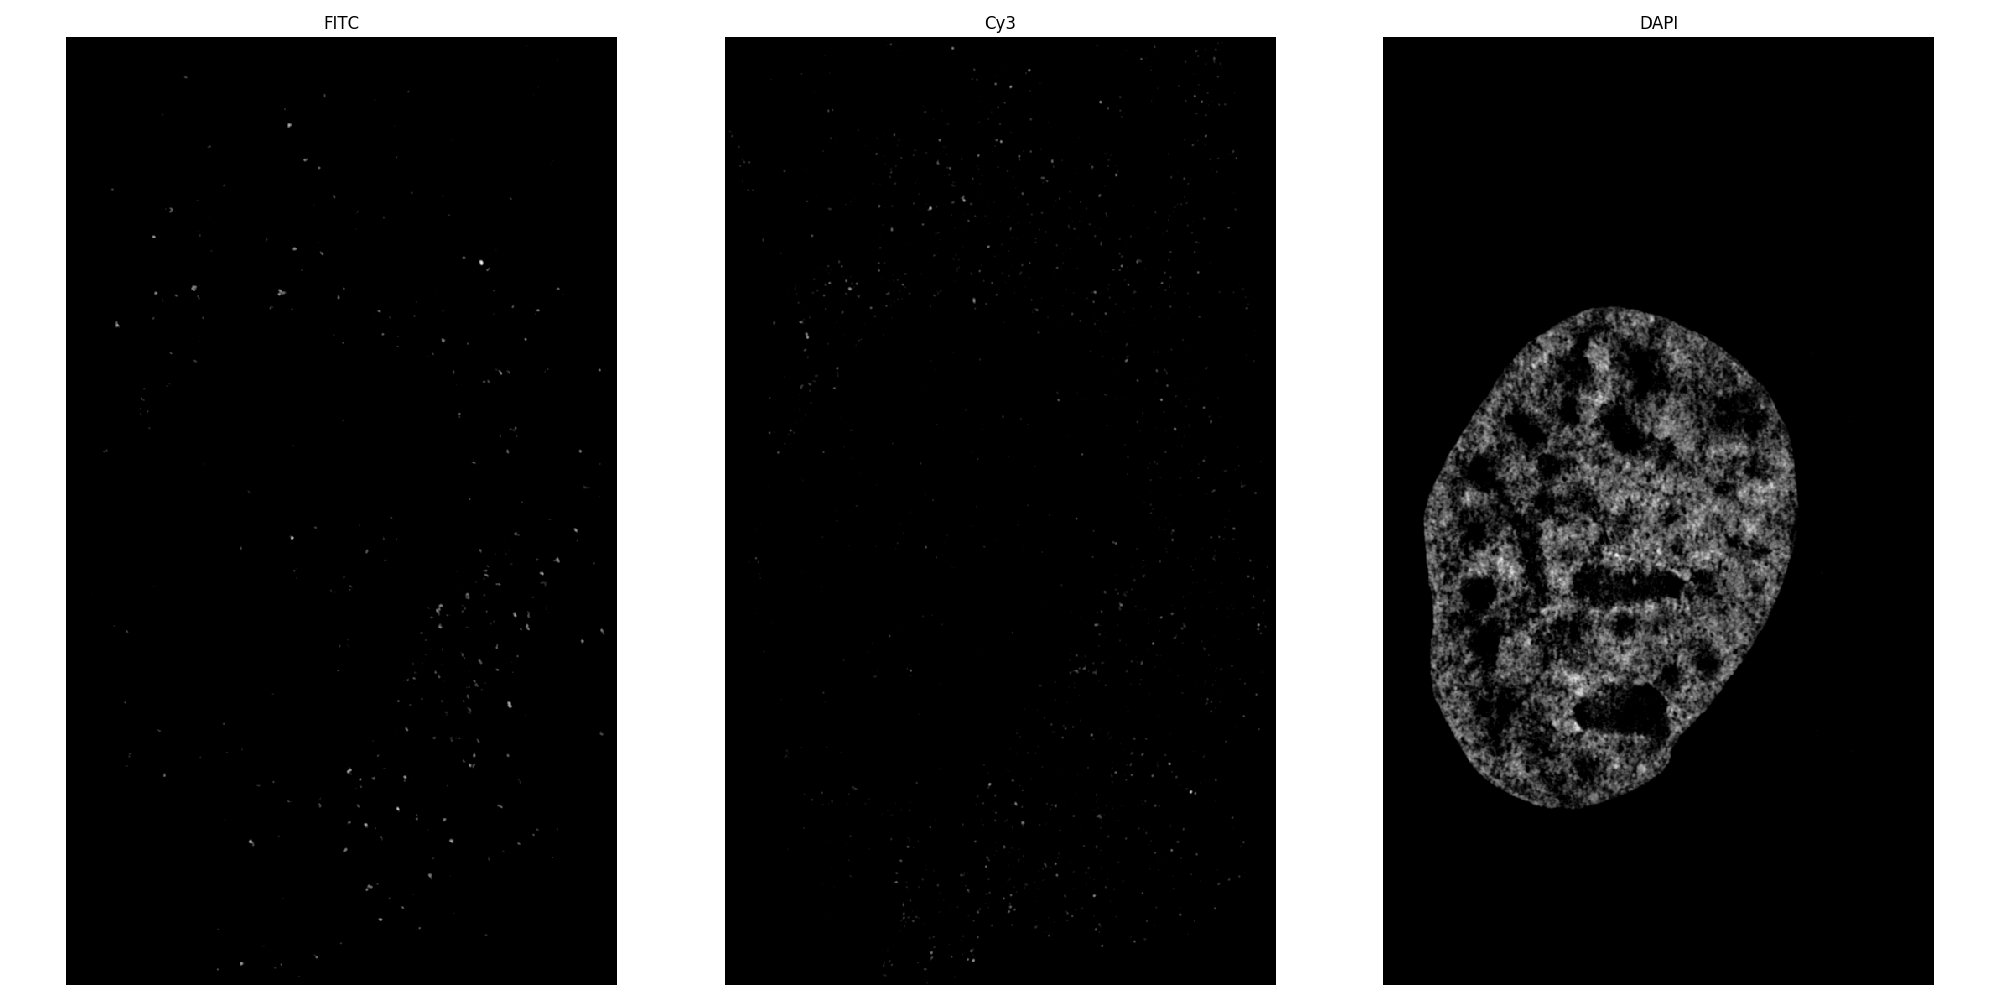

In [10]:
sim_image = sitk.ReadImage(fdata('microscopy_colocalization.nrrd'))
# The channel name appears in the image's meta-data dictionary with key: channel_i_name
channel_titles = [sim_image.GetMetaData('channel_{0}_name'.format(i)) for i in range(sim_image.GetNumberOfComponentsPerPixel())]
channels = [sitk.VectorIndexSelectionCast(sim_image,i) 
            for i in range(sim_image.GetNumberOfComponentsPerPixel())]
fitc_image = channels[channel_titles.index('FITC')]
cy3_image = channels[channel_titles.index('Cy3')]
dapi_image = channels[channel_titles.index('DAPI')]


gui.MultiImageDisplay(image_list=channels, title_list=channel_titles, shared_slider=True, 
                      intensity_slider_range_percentile=[0,100],
                      figure_size=(20,10));

## Segmenting Channels

Based on the visualization above we perform manual segmentation, visually estimating thresholds for the three channels, isolating our objects of interest.

In [11]:
fitc_threshold = 10000
cy3_threshold = 10000
dapi_threshold = 12000

# Segment the nucleus marker image and label each connected component. 
dapi_binary_segmentation = dapi_image > dapi_threshold
dapi_labeled_segmentation = sitk.ConnectedComponent(dapi_binary_segmentation)

# Segment the protein marker images and label each connected component.
markers_binary_segmentations = [fitc_image > fitc_threshold,
                                cy3_image > cy3_threshold]
markers_labeled_segmentations = [sitk.ConnectedComponent(marker_binary_segmentation) \
                                 for marker_binary_segmentation in markers_binary_segmentations]
markers_names = ['FITC', 'Cy3']

# Compute the label statistics for all protein markers. 
def apply_label_shape_filter(label_image):
    filt=sitk.LabelShapeStatisticsImageFilter()
    filt.Execute(label_image)
    return filt
markers_stats_filters = [apply_label_shape_filter(labeled_seg) for labeled_seg in markers_labeled_segmentations]

## Colocalization

The locations of the specific protien we are interested in correspond to locations where there is overlap between the markers. In our case FITC and Cy3.

<font color="red">Landon: the colocolization information is computed below, but I just stuck it into a dataframe. Please modify so that the dataframe structure is useful for your needs which I belive represent the needs of all people analyzing similar images</font>.

<font color="blue">Most medical/bio researchers I know have data management skills limited to Excel, so they're going to want single columns for each of the variables. I've made the changes. They're not pretty, but I think it's what the user would want.</font>

In [46]:
# Compute the colocalization image and label each connected component.
colocalization_binary_segmentation = markers_binary_segmentations[0]
for binary_segmentation in markers_binary_segmentations[1:]:
    colocalization_binary_segmentation = colocalization_binary_segmentation * binary_segmentation
colocolization_labeled_segmentation = sitk.ConnectedComponent(colocalization_binary_segmentation)    

# Compute the label statistics for the colocalized protein markers.
colocolization_stats_filter = sitk.LabelShapeStatisticsImageFilter()
colocolization_stats_filter.Execute(colocolization_labeled_segmentation)

# Create a dictionary that maps between the colocalization labels and the individual labels from
# each marker.
colocalization_labels_2_original_labels = {}
colocolization_labeled_segmentation_arr_view = sitk.GetArrayViewFromImage(colocolization_labeled_segmentation)
for label in colocolization_stats_filter.GetLabels():
    label_indexes = np.where(colocolization_labeled_segmentation_arr_view == label)
    index = (int(label_indexes[2][0]), 
             int(label_indexes[1][0]), 
             int(label_indexes[0][0]))
    colocalization_labels_2_original_labels[label] = [labeled_seg[index] for labeled_seg in markers_labeled_segmentations]


# Compute statistics for the colocalizations. Work with a list of lists and then 
# combine into a dataframe, faster than appending to the dataframe one by one.
#column_titles = ['colocalization size [mm, voxels]'] + [ch_title+' [label, size [mm], size[voxels], colocalization percentage]' for ch_title in markers_names]
column_titles = ['colocalization size', ''] + [item for sublist in [[marker, "", "", ""] for marker in markers_names] for item in sublist]
all_colocalizations_data = []
for item in colocalization_labels_2_original_labels.items():
    coloc_size = colocolization_stats_filter.GetPhysicalSize(item[0])
    marker_labels_list = item[1]
    current_colocalization = [coloc_size, colocolization_stats_filter.GetNumberOfPixels(item[0])] + \
                             [item for sublist in [[label,filt.GetPhysicalSize(label),filt.GetNumberOfPixels(label),coloc_size/filt.GetPhysicalSize(label)] 
                                                   for label,filt in zip(marker_labels_list, markers_stats_filters)] for item in sublist]
    all_colocalizations_data.append(current_colocalization)
    
colocalization_information_df = \
    pd.DataFrame(all_colocalizations_data, columns=column_titles)
marker_columns = ['label', 'size [mm]', 'size[voxels]', 'colocalization percentage']
colocalization_information_df.columns = pd.MultiIndex.from_tuples(zip(colocalization_information_df.columns, 
                                          ['mm', 'voxels'] + [item for sublist in [marker_columns for item in markers_names] for item in sublist]))

# Save the colocalization results
colocalization_information_df.to_csv(os.path.join(OUTPUT_DIR,'colocalization.csv'), index=False)


# Display the first N rows as HTML
head_length=20
formatters={('colocalization size','[mm, voxels]'): lambda x: '{0:.3f}, {1}'.format(x[0],x[1])}
marker_formatter = lambda x: '{0}, {1:.3f}, {2}, {3:.3f}'.format(x[0],x[1],x[2],x[3])
for col_title in column_titles[1:]:
     formatters[(col_title,'[label, size [mm], size[voxels], colocalization percentage]')] = marker_formatter
display(HTML(colocalization_information_df.head(head_length).to_html(formatters=formatters, index=False)))



<font color="red">Landon: Not sure what exactly we want to do here so below is an initial guess. Any additional background story helps.</font>

I assume there are multiple nuclei and that we don't care about a specific nucleus to protein distance, just that the distance to a nucleus is below
our threshold. 

I looked at the DAPI image and I assume this is a single nucleus (not sure as I dont' work with these types of images). In any case, if I look at the connected components from the binary image I get multiple objects, so I decided just to go with the distance map computations that treat a single or multiple objects in the same manner.



We can have a GUI, slider, so that the user interactively selects the threshold.

<font color='blue'>I haven't been able to get the sitk.Show() functions to work, however, just judging by the code I prefer option B. I think finer grain quantification is the way to go. We mostly work with images that have single nuclei here, but it shouldn't matter if there are more since a signal will be assumed to be associated with whatever nucleus it's closest to.</font>



## Option A

In [13]:
distance_map_from_all_nuclei = sitk.Abs(sitk.SignedMaurerDistanceMap(dapi_binary_segmentation, squaredDistance=False, useImageSpacing=True))

sitk.Show(distance_map_from_all_nuclei)

# Get the maximal distance and divide into equaly spaced thresholds.
num_thresholds = 10
max_dist = np.max(sitk.GetArrayViewFromImage(distance_map_from_all_nuclei))
thresholds = np.linspace(max_dist/num_thresholds, max_dist, num_thresholds)

for thresh in thresholds:
    current_colocalizations = colocolization_labeled_segmentation * \
                              sitk.Cast((distance_map_from_all_nuclei<thresh), colocolization_labeled_segmentation.GetPixelIDValue())
    arr_view = sitk.GetArrayViewFromImage(current_colocalizations)
    number_of_unique_colocalizations = len(np.unique(arr_view[arr_view!=0]))
    print(number_of_unique_colocalizations)
    sitk.Show((current_colocalizations!=0)*255)            

RuntimeError: Exception thrown in SimpleITK Show: /tmp/SimpleITK/Code/IO/src/sitkShow.cxx:582:
sitk::ERROR: Error in administrating child process: [No such file or directory].
Command line: '/Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP' '/tmp/TempFile-11588-2.nii' 

## Distance of colocalizations from nucleus - Option B 

In [15]:
distance_map_from_all_nuclei = sitk.Abs(sitk.SignedMaurerDistanceMap(dapi_binary_segmentation, squaredDistance=False, useImageSpacing=True))

sitk.Show(distance_map_from_all_nuclei)

distance_stats_filter = sitk.LabelIntensityStatisticsImageFilter()
distance_stats_filter.Execute(colocolization_labeled_segmentation, distance_map_from_all_nuclei)

labels_edge_distances = []
for label in distance_stats_filter.GetLabels():
    labels_edge_distances.append([colocalization_labels_2_original_labels[label],distance_stats_filter.GetMinimum(label)]) # This is edge to edge distance
    
distances_df = pd.DataFrame(labels_edge_distances, columns=['original labels', 'distances [mm]'])
distances_df.to_csv(os.path.join(OUTPUT_DIR,'colocalization_edge_edge_distances.csv'), index=False)

## Distance of object from nuclear center

Determining how close proteins (or genes if that is your interest) is to the center of the nucleus.

<font color='blue'>You're correct in that the distance of the nucleus from the protein is terribly important. Symmetry of results should not matter as long as we have one or the other.</font>

In [48]:
#create two lists of tuples, label-center, just using the first two segmented marker channels. This are likely\n",
#not the two sets of points we are interested in, but I am not sure if we have a single nuclues or nuclei in the\n",
#DAPI, so this code deals with multiple centers in both images by using the two marker channels.\n",
centroid_lists = []
for i in range(2):
    centroid_lists.append([(label, markers_stats_filters[i].GetCentroid(label)) for label in markers_stats_filters[i].GetLabels()])
    
labels0, centroids0 = zip(*centroid_lists[0])
centroids0 = np.array(centroids0)
labels1, centroids1 = zip(*centroid_lists[1])
centroids1 = np.array(centroids1)


# Compute minimal distances and matching labels
all_distances = -2 * np.dot(centroids0, centroids1.T)
all_distances += np.sum(centroids0**2, axis=1)[:, np.newaxis]
all_distances += np.sum(centroids1**2, axis=1)
all_distances = np.sqrt(all_distances)

min_indexes = np.argmin(all_distances, axis=1)
results = list(zip(labels0, tuple(np.array(labels1)[min_indexes]), all_distances[np.arange(len(min_indexes)), min_indexes]))
print(results)

[(1, 16, 0.28042146083217895), (2, 58, 0.10395169978163578), (3, 2575, 0.1184869680485518), (4, 5, 0.25868498313306465), (5, 225, 0.21255150033281012), (6, 1429, 0.09205226118551793), (7, 246, 0.11057383910181046), (8, 259, 0.14939604596010622), (9, 523, 0.22830625978347774), (10, 130, 0.14447683350842588), (11, 333, 0.16352735137974844), (12, 914, 0.0654064734945701), (13, 348, 0.33456462181266644), (14, 348, 0.19453606046104888), (15, 946, 0.4413304428238815), (16, 164, 0.13564093524213286), (17, 604, 0.05493700594697115), (18, 167, 0.09867107527833419), (19, 609, 0.3082939823906368), (20, 611, 0.0408418259191958), (21, 63, 0.11524475107986923), (22, 365, 0.1886262380754414), (23, 177, 0.16956045863709943), (24, 376, 0.16699768007177282), (25, 1663, 0.6206804883861856), (26, 69, 0.1370257163477562), (27, 186, 0.20687304642235743), (28, 649, 0.17297515674445973), (29, 396, 0.2024283122929343), (30, 202, 0.717342337137112), (31, 80, 0.1855399918234716), (32, 702, 0.15197873545571566), 